# A Global Community-Based Training Program

Since 2020, the OLS community has run 8 cohorts successfully with the engagement of over 500 international community members.

In [1]:
import geopandas
import geodatasets
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from wordcloud import WordCloud

In [2]:
baseurl = "https://raw.githubusercontent.com/open-life-science/open-life-science.github.io/main/_data/artifacts/openseeds/"
cohort_nb = 9

In [3]:
people_df = pd.read_csv(f"{baseurl}people.csv", index_col=0).fillna("")

In [4]:
roles_df = {}
roles = []
for r in ["role", "participant", "mentor", "expert", "speaker", "facilitator", "organizer"]:
    role = r.capitalize()
    roles.append(role)
    roles_df[role] = pd.read_csv(f"{baseurl}/roles/{r}.csv", index_col=0)

# Cohort stats

In [5]:
red_roles = ["Participant", "Mentor", "Facilitator", "Speaker", "Expert"]
role_count_df = pd.DataFrame(columns = red_roles)
for r in red_roles:
    role_count_df[r] = (
        roles_df[r]
        .drop(columns = ["city", "country", "country_3", "first-name", "last-name", "pronouns", "continent", "longitude", "latitude"])
        .count(axis=0)
        .rename(index=str.upper)
    )
    role_count_df.loc["Total", r] = len(roles_df[r])
role_count_df = role_count_df.astype("int64")
role_count_df

Participant  Mentor  Facilitator  Speaker  Expert
OLS-1           29      20            0       18      37
OLS-2           52      36            0       24      65
OLS-3           66      34            1       22      63
OLS-4           34      32            7       18      46
OLS-5           71      35            5       17      26
OLS-6           41      32            7       19      39
OLS-7           54      34           10       18       4
OLS-8           69      38           15       12      22
Total          386     138           30       99     170

# Development path of people in the different roles and Alumni 

In [6]:
cohorts = [x.lower() for x in list(role_count_df.index)]
labels = [x.lower() for x in red_roles] + ["alumni"]
role_flow_df = pd.DataFrame({
    "source": [l for subl in [[l]*len(labels) for l in labels] for l in subl], 
    "target": labels*len(labels), 
    "value": 0
})

for index, row in role_flow_df.iterrows():
    if row.source == "alumni":
        continue
    elif row.target == "alumni":
        for i in range(len(cohorts)-2):
            source = f"{cohorts[i]}-{row.source}"
            # build query with any role in the cohort and no role after in the following cohort
            query = f"`{source}` != ''"
            for r in red_roles:
                target = f"{cohorts[i+1]}-{r.lower()}"
                query += f"and `{target}` == ''"
            role_flow_df.at[index, "value"] += len(people_df.query(query))
    else:
        for i in range(len(cohorts)-2):
            source = f"{cohorts[i]}-{row.source}"
            target = f"{cohorts[i+1]}-{row.target}"
            # build query the source role for a cohort and target role for the following cohort
            query = f"`{source}` != '' and `{target}` != ''"
            query_res = people_df.query(query)
            # check for each result how many roles in cohort and following cohort to normalize the value
            value = 0
            for q_i, q_r in query_res.iterrows():
                new_role_nb = len(q_r[f"{cohorts[i+1]}-role"].split(","))
                value += 1/(new_role_nb)
            role_flow_df.at[index, "value"] += value

In [9]:
colors = {
    "participant": "#3182bd",
    "mentor": "#fd8d3c",
    "expert": "#d9d9d9",
    "speaker": "#dadaeb",
    "facilitator": "#a1d99b",
    "alumni": "grey"
}
label_df = pd.DataFrame({
    "labels": [l.capitalize() for l in labels] * 2, 
    "colors": [colors[l] for l in labels] * 2, 
    "x": [0.1]*len(labels)+[0.9]*len(labels), 
    "y": [0.1]*(len(labels)*2)})

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = label_df.labels,
        color = label_df.colors,
    ),
    link = dict(
      source = [labels.index(e) for e in role_flow_df.source],
      target = [labels.index(e)+len(labels) for e in role_flow_df.target],
      value = role_flow_df.value
  ))])

fig.update_layout(
    font_size=18,
    width=950,
    height=400,
    margin=go.layout.Margin(
        l=10, #left margin
        r=10, #right margin
        b=20, #bottom margin
        t=20, #top margin
    )
)

fig.show()

Participants re-joining (%)

In [10]:
role = "participant"
role_nb = float(role_flow_df.query(f"source == '{ role }'").value.sum())
role_wo_alumni = float(role_flow_df.query(f"source == '{ role }' and target != 'alumni'").value.sum())
100 * role_wo_alumni  / role_nb

26.153846153846153

Mentors re-joining (%)

In [11]:
role = "mentor"
role_nb = float(role_flow_df.query(f"source == '{ role }'").value.sum())
role_wo_alumni = float(role_flow_df.query(f"source == '{ role }' and target != 'alumni'").value.sum())
100 * role_wo_alumni  / role_nb

57.53238436562595

# People location 

In [12]:
map_fp = Path("../data/naturalearth_lowres/naturalearth_lowres.shp")
world_df = geopandas.read_file(map_fp).rename(columns = {"SOV_A3": "iso_a3"})

In [13]:
country_code_df = (roles_df["Role"].groupby(["country_3"]).count()
    .rename(columns = {"country": "total"})
    .drop(columns = ["city", "first-name", "last-name", "pronouns", "continent", "longitude", "latitude"])
)

Number of countries:

In [14]:
len(country_code_df)

55

In [15]:
country_code_df[country_code_df != 0] = 1
country_code_df = (country_code_df
    .rename_axis("iso_a3")
    .reset_index()
)
country_world_df = pd.merge(world_df, country_code_df, on='iso_a3', how='outer')
country_world_df['total'] = country_world_df['total'].fillna(0)
for i in range(1, cohort_nb):
    country_world_df[f'ols-{i}'] = country_world_df[f'ols-{i}'].fillna(0)

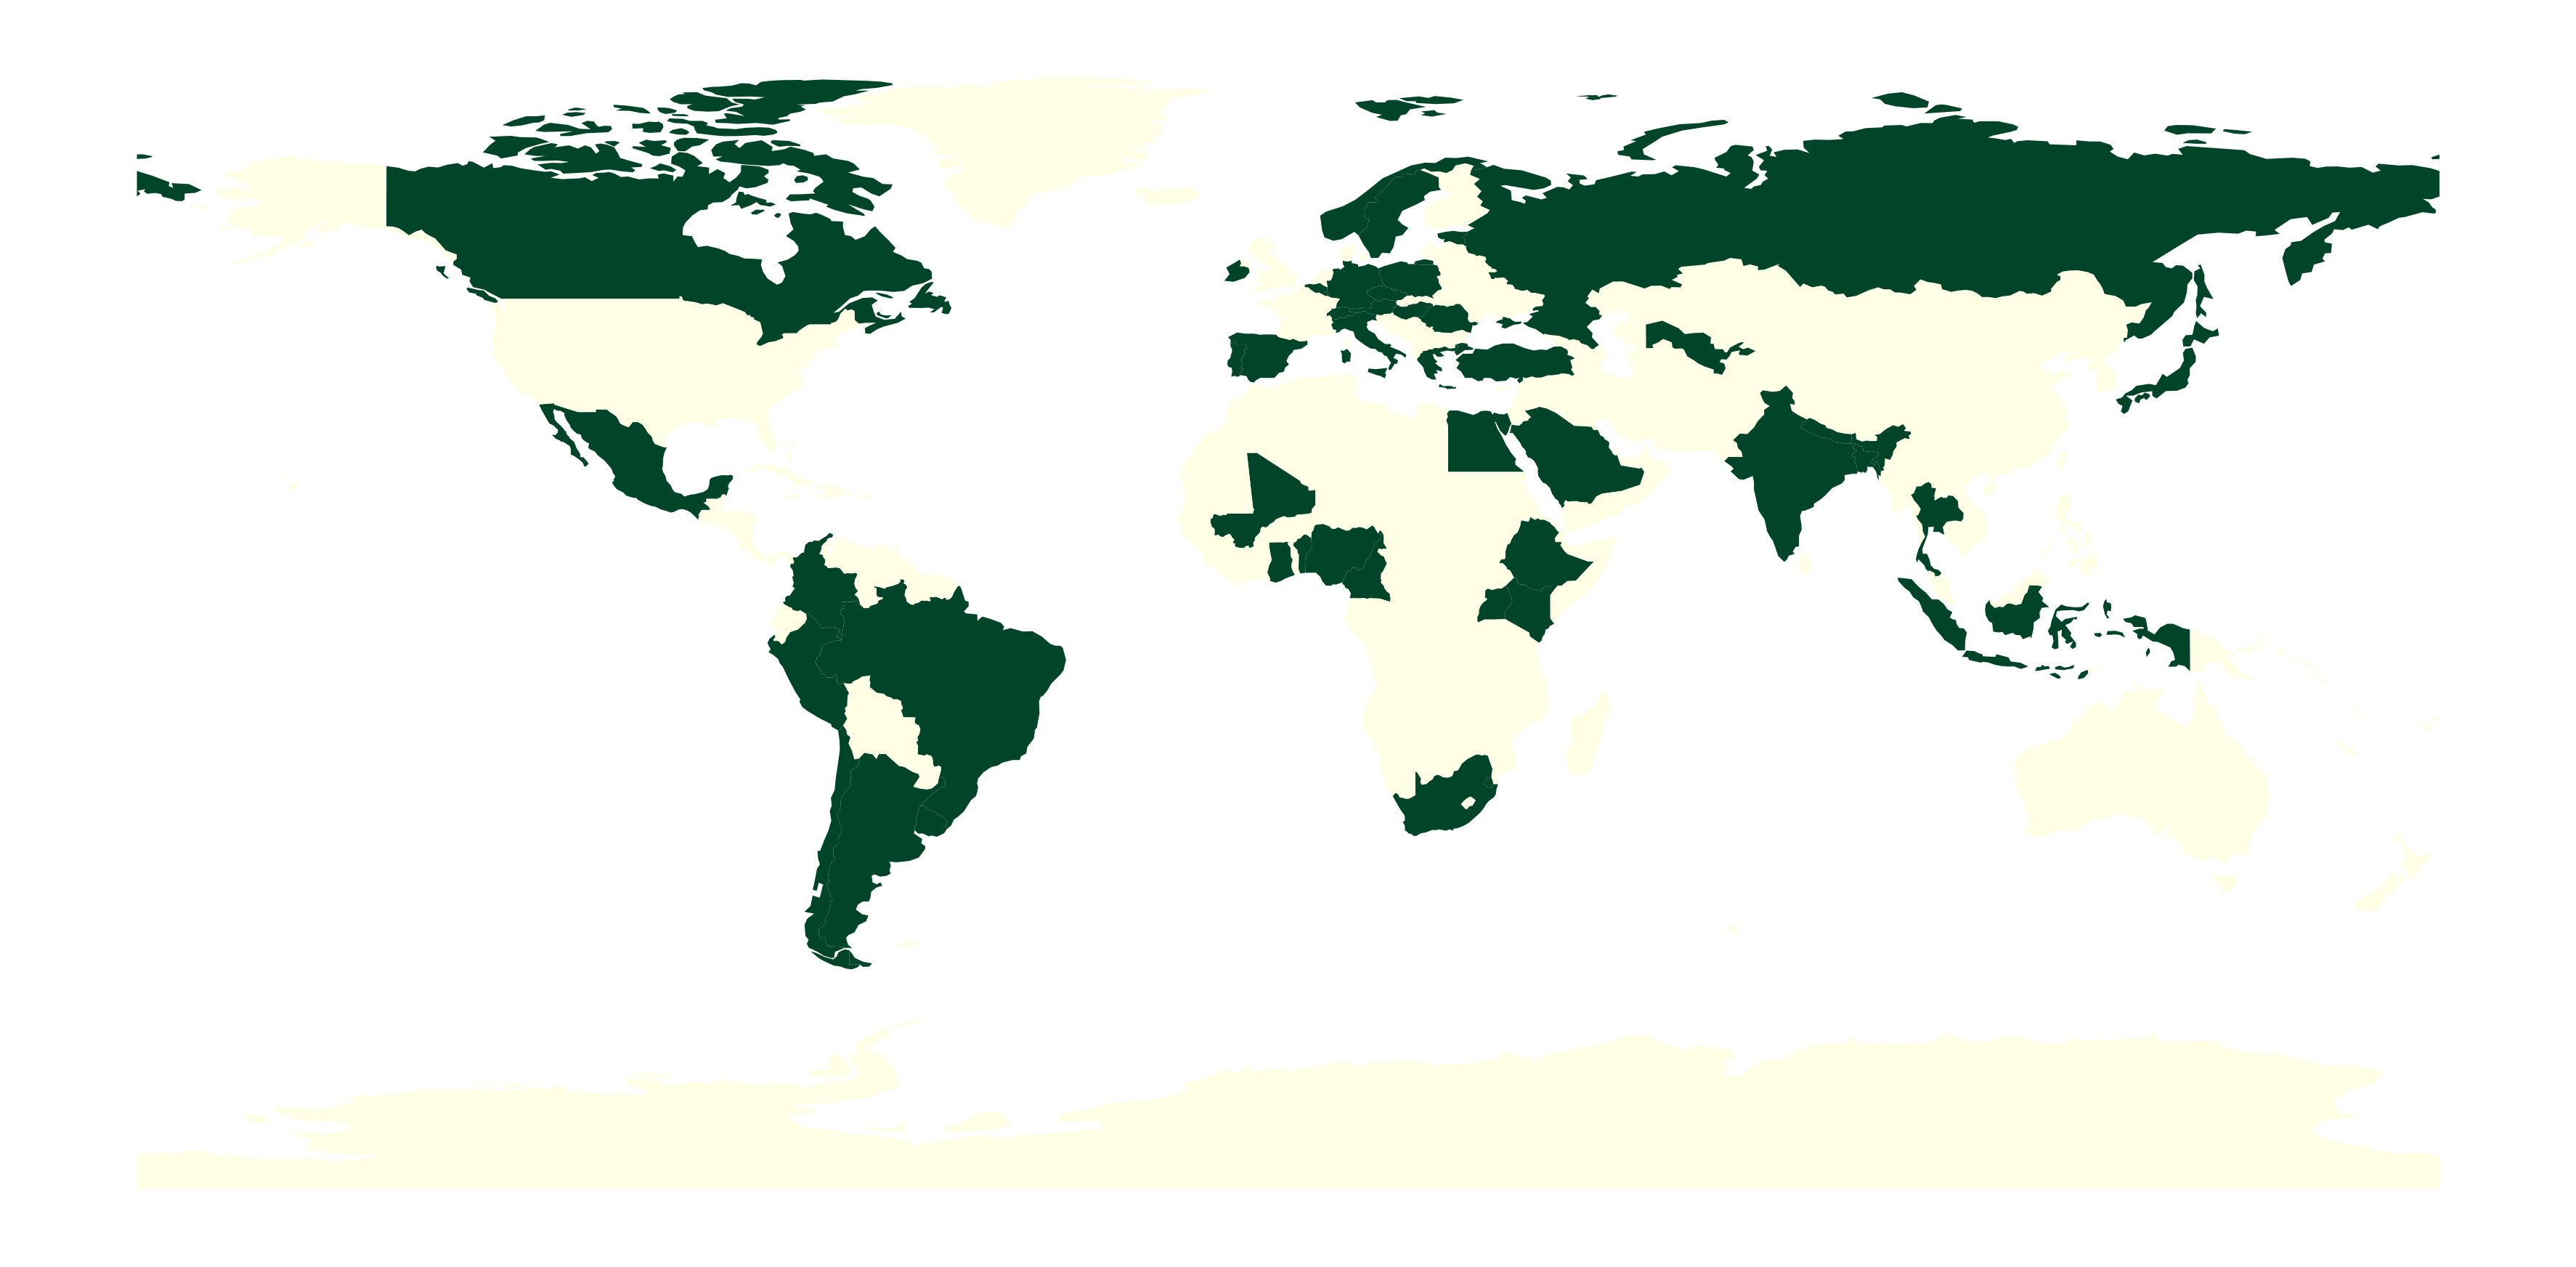

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.set_dpi(300)

country_world_df.plot(
    column='total',
    ax=ax,
    legend=False,
    cmap='YlGn')
ax.set_axis_off()

plt.savefig(f'all-roles-all-cohorts.png', bbox_inches='tight')

# Projects

In [17]:
baseurl = "https://raw.githubusercontent.com/open-life-science/open-life-science.github.io/main/_data/artifacts/openseeds/"
project_df = (
    pd.read_csv(f"{baseurl}projects.csv", index_col=0, na_filter=False)
    .assign(
        participants=lambda df: df.participants.str.split(", "),
        participantNb=lambda df: df.participants.str.len(),
        mentors=lambda df: df.mentors.str.split(", "),
        keywords=lambda df: df.keywords.str.split(", "),
        cohort=lambda df: "OLS-" + df.cohort.astype(str),
    )
)

## Cohorts

Number of projects over all cohorts

len(project_df)

In [18]:
cohort_df = (
    project_df
    .groupby(by="cohort")
    .count()
    .drop(columns = ["participants", "mentors", "description", "keywords", "status", "collaboration", "participantNb"])
    .rename(columns = {"name": "Total"})
)

Aggregating statistic of number of projects per cohort

In [19]:
cohort_df.Total.describe()

count     8.000000
mean     29.750000
std       5.391793
min      20.000000
25%      26.750000
50%      30.500000
75%      33.250000
max      37.000000
Name: Total, dtype: float64

Mean number of projects per cohort

In [20]:
cohort_df.Total.median()

np.float64(30.5)

## Participants

Aggregating statistic of the number of participants per projects

In [21]:
project_df.participantNb.describe()

count    238.000000
mean       1.756303
std        1.346766
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: participantNb, dtype: float64

## Keywords

In [22]:
keyword_df = (project_df
    .drop(columns = ["participantNb", "participants", "mentors", "description", "status", "cohort", "collaboration", "status", "graduation"])
    .explode("keywords")
    .assign(keywords=lambda df: df.keywords.str.capitalize())
    .replace("Community building", "Community")
    .replace("Research community", "Community")
    .replace("Ethics of ai", "Ethical AI")
    .replace("Ethical ai", "Ethical AI")
    .replace("Enviromental", "Environmental science")
    .replace("Equal opportunity", "Equality")
    .replace("Training", "Training and education")
    .replace("Education", "Training and education")
    .replace("Artificial intelligence", "AI")
    .replace("Ai", "AI")
    .replace("Fair", "FAIR")
    .replace("Open-source", "Open source")
    .replace("Open source software", "Open source")
    .replace("Opensource", "Open source")
    .replace("Os", "Open source")
    .replace("Open source projects", "Open source")
    .replace(" data science", "Data science")
    .replace("Visualisation", "Data visualisation")
    .replace("Next-generation sequencing", "Sequencing")
    .replace("Open educational resource", "Open education")
    .replace("Reproducible research", "Reproducibility")
    .replace("Data", "Data science")
    .replace("Open community", "Community")
    .groupby(by="keywords")
    .count()
    .rename(columns={"name": "Frequency"})
    .sort_values("Frequency", ascending=False)
)

In [23]:
frec = keyword_df.Frequency.to_dict()

wc = WordCloud(
    background_color="rgba(255, 255, 255, 0)",
    random_state=42,
    width=600,
    height=400,
)

wordcloud = wc.generate_from_frequencies(frec)

## Graduation stats

Percentage of graduated project

In [24]:
100 * len(project_df.query('status == "graduated"'))/len(project_df.status)

79.41176470588235

Percentage of graduated project within collaboration

In [25]:
100 * len(project_df.query('status == "graduated" and collaboration != ""'))/len(project_df.query('collaboration != ""'))

94.11764705882354

Projects that did not graduated

In [27]:
non_graduated_project = (
    project_df.query('status != "graduated"')
    .drop(columns=["description", "keywords", "status", "graduation", "collaboration", "participantNb"])
)
non_graduated_project["participants"] = non_graduated_project["participants"].apply(lambda x: ", ".join(str(i) for i in x))
non_graduated_project["mentors"] = non_graduated_project["mentors"].apply(lambda x: ", ".join(str(i) for i in x))
#non_graduated_project.to_csv("../results/openseeds/non_graduated_project.csv", sep="\t", index=False)

Project that did graduated but came back

In [33]:
len(project_df[project_df.name.duplicated(keep=False)]["name"].unique())

3

## Overview figure

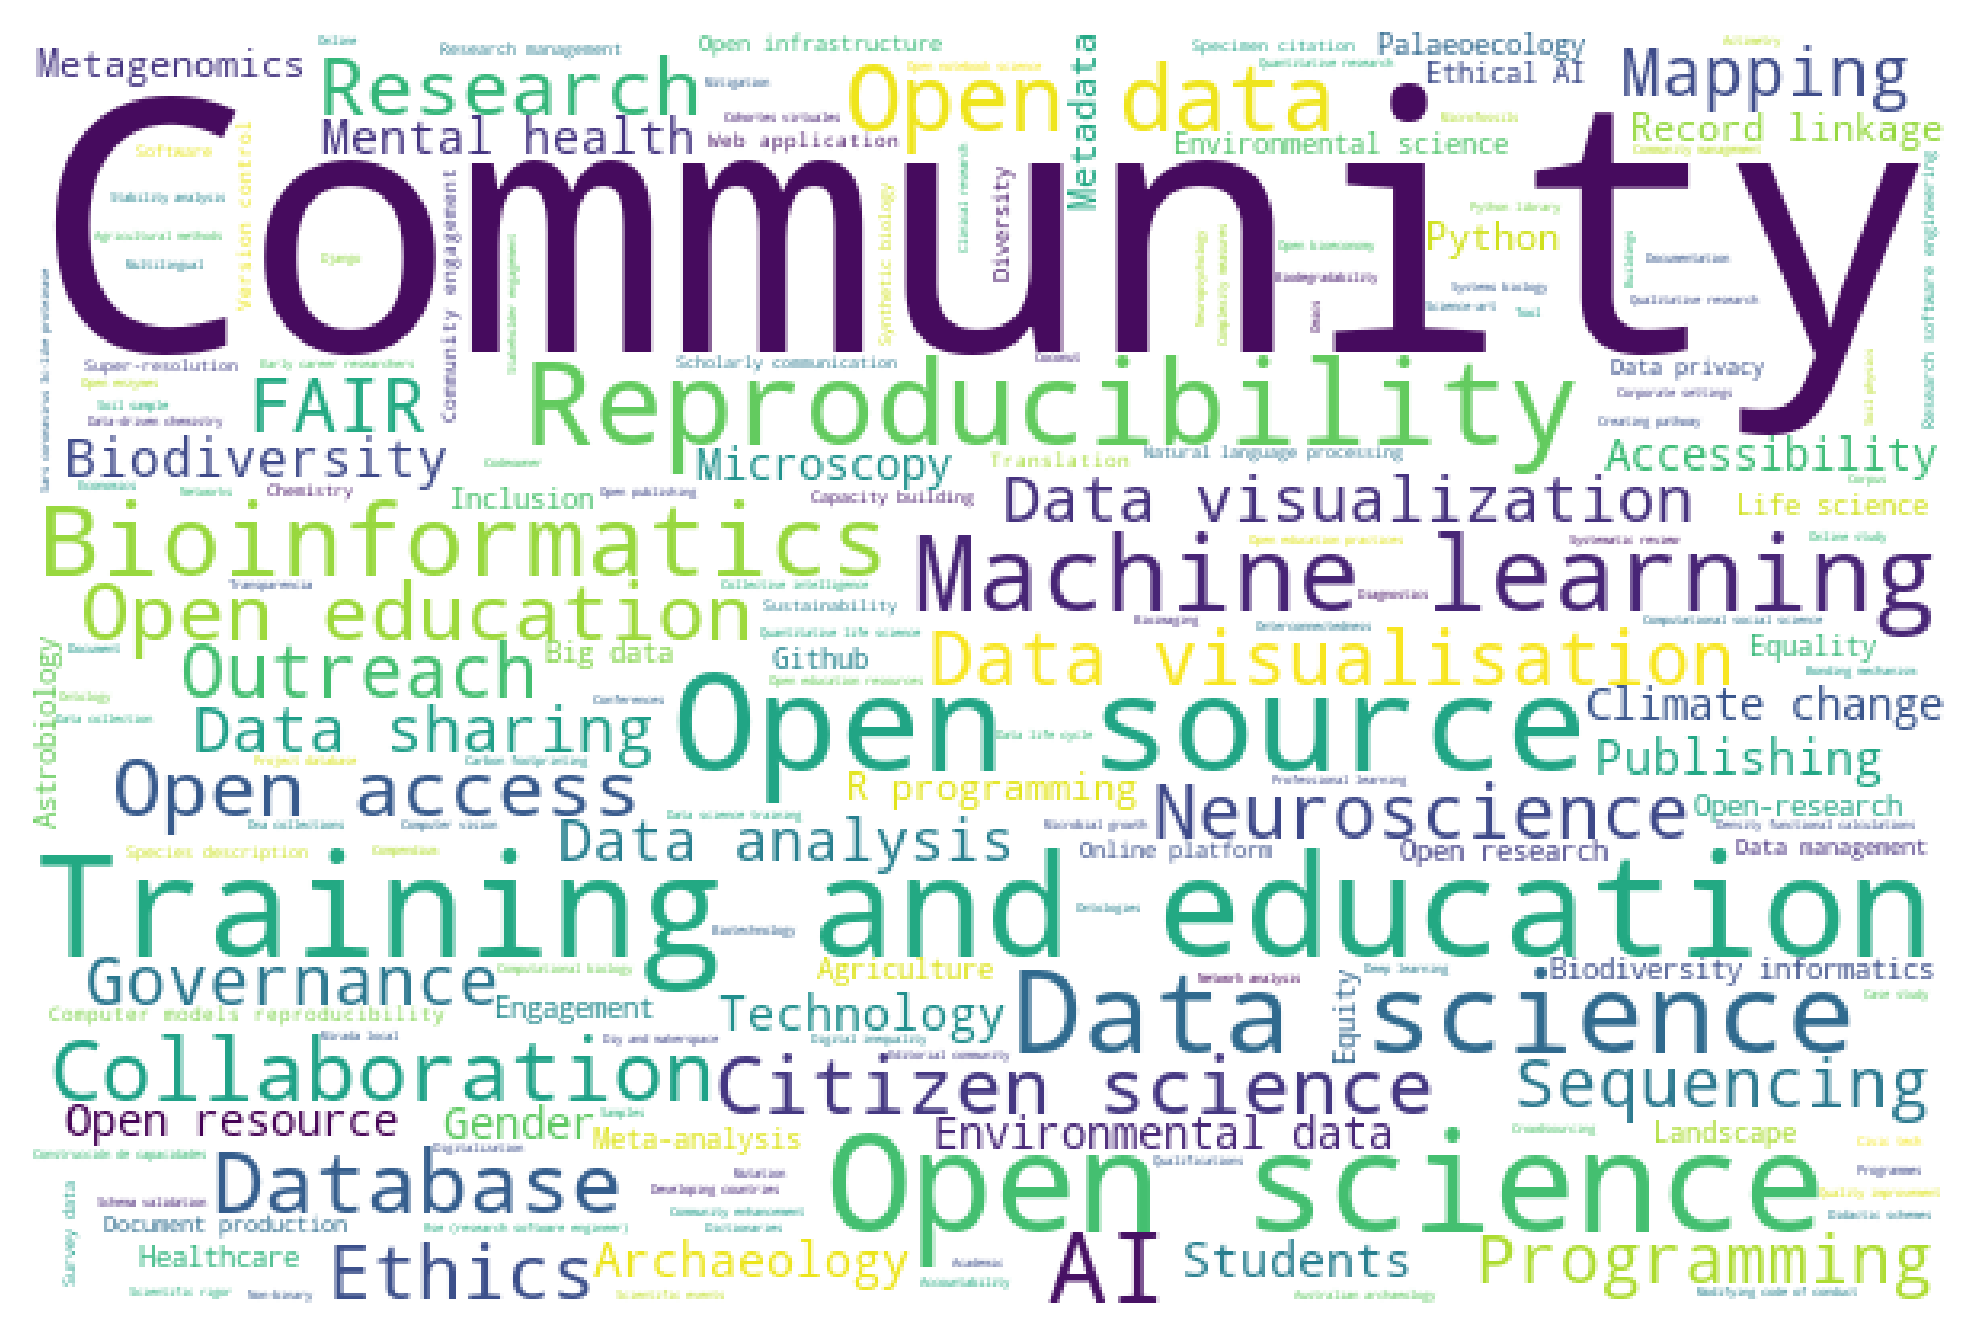

Text(0.5, 0, 'Number of participants per projects')

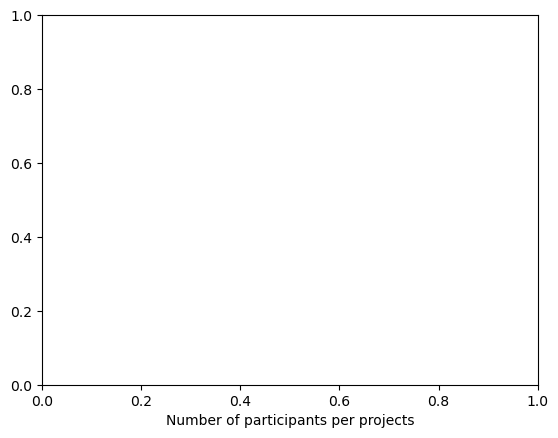

In [34]:
fig, ax = plt.subplots()
fig.set_dpi(300)

# A
ax.imshow(wc)

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# B
project_df.participantNb.plot.hist(
    bins=8, ax=ax, legend=False, color="#139D3D"
)
plt.xlabel('Number of participants per projects')